[View in Colaboratory](https://colab.research.google.com/github/Mathis1993/Leaf-Classification-CNN/blob/master/Complete_Workflow.ipynb)

# Plant Species Classification using a CNN

<img src="http://drive.google.com/uc?export=view&id=1JyQxgUQk_K4v3LGdeFJlBMABN-WKJt6b">

## Introduction

In the course of learning about AI at [TechLabs](https://tech-labs.de/), we realized a small project to classify plant species using a Convolutional Neural Network (CNN).

In 2012, Neeraj Kumar et al. developed [Leafsnap: A Computer Vision System for Automatic Plant Species Identification](https://neerajkumar.org/base/papers/nk_eccv2012_leafsnap.pdf), a mobile app that identifies all 185 tree species in the Northeastern United States using pictures of their leaves. The classification process is based on a computer vision sytem. This system segments the leaf from its background, extracts curvature features of the leaf's contour and classifies it against a dataset containing examples of all the 185 tree species. With this procedure, a top-1 score of about 72% is achieved (meaning that in 72% of cases, the tree species class the computer vision systems assigns the highest probability to is the correct one). 

Examples of 180 of the 185 different plant species can be examined in the image above.

Using this same dataset, that the authors of the paper make available [here](leafsnap.com/dataset/), we asked ourselves if we could possibly beat the traditional computer vision system's performance by implementing the classification task via a CNN. To maximize our learning success, we did not use a pretrained CNN, but built our own network architecture.

In this post, we want to give a full overview of all the steps we took to train our CNN to classify Northeastern American tree species.

Due to limited computational resources on our private hardware, we used [Google Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb), Google's free cloud service for developing deep Iearning applications on a GPU. We will show the necessary steps for getting ready to work, a detailed tutorial is available on [medium](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d).

## Google Colaboratory

In order to use Google Colaboratory, we worked in a IPython Notebook located in a Google Drive storage. 

**Important**: To use the free GPU, go to "Edit-->Notebook Settings" and select "GPU" as hardware accelerator. 

Once connected, Drive can be mounted to Google Colab so that files stored in Drive will be available using the code snippet below.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Then, we can navigate to the desired directory...

In [2]:
%cd /content/drive/My Drive/Colab Notebooks/CNN-Model-files

/content/drive/My Drive/Colab Notebooks/CNN-Model-files


... and start working.

## Preprocessing

Consisting of the following steps:
1. Import packages
2. Read data frame with information about pictures
3. Create numeric labels
4. Resize Pictures 
6. Read pictures as RGB arrays
7. Randomize picture order
8. Stack picture input into one array
9. Normalize input features (pictures) and one-hot encode labels
9. Save input features, labels and further info

### 1. Import packages

As a first step, we import the packages necessary for preprocessing the data. 

If a package needs to be installed, do:

In [0]:
!pip install imageio

In [6]:
import os
import PIL
import imageio
import pandas as pd
import numpy as np
import random
import math
import keras

Using TensorFlow backend.


### 2. Read data frame with information about pictures

In the dataset, there is a data frame containing information about the pictures. Relevant for us are the columns:
- path: path to the individual pictures
- species: latin term for each plant
- source: picture taken in lab or field

In [10]:
img_info = pd.read_csv("./leafsnap-dataset-images.txt", sep="\t")
img_info.head()

,file_id,image_path,segmented_path,species,source
0,55497,dataset/images/lab/abies_concolor/ny1157-01-1.jpg,dataset/segmented/lab/abies_concolor/ny1157-01...,Abies concolor,lab
1,55498,dataset/images/lab/abies_concolor/ny1157-01-2.jpg,dataset/segmented/lab/abies_concolor/ny1157-01...,Abies concolor,lab
2,55499,dataset/images/lab/abies_concolor/ny1157-01-3.jpg,dataset/segmented/lab/abies_concolor/ny1157-01...,Abies concolor,lab
3,55500,dataset/images/lab/abies_concolor/ny1157-01-4.jpg,dataset/segmented/lab/abies_concolor/ny1157-01...,Abies concolor,lab
4,55501,dataset/images/lab/abies_concolor/ny1157-02-1.jpg,dataset/segmented/lab/abies_concolor/ny1157-02...,Abies concolor,lab


We create a new column only holding the filenames and not the whole path to each picture, so that we can assess the filenames for later resizing of the pictures.

In [0]:
#new column (empty)
img_info["filename"] = None
#index of new column
index_filename = img_info.columns.get_loc("filename")
for i in range(len(img_info)):
    img_info.iloc[i, index_filename] = os.path.basename(str(img_info["image_path"][i]))

### 3. Create numeric labels

Then, we want to have numeric labels instead of the latin term for each plant, so we append another column holding these.
- In the data frame, all images of one species are listed consecutively (first the lab images, then the field images)
- Therefore we just loop over the dataframe and increment the numeric label whenever we encounter a latin term that differs from the previous one

In [36]:
#new column (empty)
img_info["labels_integer"] = None
#index of new column
index_labels_integer = img_info.columns.get_loc("labels_integer")
#index of species column
index_species = img_info.columns.get_loc("species")
#to assign numeric labels starting with 0 for the first species
k = 0 
for i in range(len(img_info)):
    if i == 0:
        img_info.iloc[i, index_labels_integer] = k #here, k == 0
    if i > 0:
        if img_info.iloc[i-1, index_species] == img_info.iloc[i, index_species]:
            img_info.iloc[i, index_labels_integer] = k
        else:
            k += 1
            img_info.iloc[i, index_labels_integer] = k
img_info.tail()

,file_id,image_path,segmented_path,species,source,filename,labels_integer
30861,83817,dataset/images/field/ulmus_rubra/1300222828248...,dataset/segmented/field/ulmus_rubra/1300222828...,Ulmus rubra,field,13002228282488.jpg,184
30862,83818,dataset/images/field/ulmus_rubra/1300222828261...,dataset/segmented/field/ulmus_rubra/1300222828...,Ulmus rubra,field,13002228282613.jpg,184
30863,83819,dataset/images/field/ulmus_rubra/1300222828265...,dataset/segmented/field/ulmus_rubra/1300222828...,Ulmus rubra,field,13002228282655.jpg,184
30864,83820,dataset/images/field/ulmus_rubra/1300222828617...,dataset/segmented/field/ulmus_rubra/1300222828...,Ulmus rubra,field,13002228286176.jpg,184
30865,83821,dataset/images/field/ulmus_rubra/1300222828044...,dataset/segmented/field/ulmus_rubra/1300222828...,Ulmus rubra,field,13002228280448.jpg,184


Save data frame.

In [0]:
img_info.to_csv("img_info.csv", index=False)

### 4. Resize pictures

Next on the list: Resizing the pictures. This is done by reading the filenames from the data frame, generating a cropped version of the desired size for each picture and saving them to an output directory.

In [0]:
def resizeImage(infile, infile_name_only, output_dir="", size=(1024,768)):
  '''
  Resize Images to a requestet size (not considerinng aspect ratio)
  Input:
  - infile: image to be resized (with path)
  - infile_name_only: image to be resized (filename only)
  - output_dir: where resized images should be stored
  - size: output size (tupel of (height, width))
  '''
  
  outfile = os.path.splitext(infile_name_only)[0]
  extension = os.path.splitext(infile)[1]
  
  if infile != outfile:
    if not os.path.isfile(output_dir + "/" + outfile + extension):
      try :
        im = PIL.Image.open(infile)
        #crops to requested size independt from aspec ratio
        im = im.resize(size, PIL.Image.ANTIALIAS) 
        im.save(output_dir + "/" + outfile + extension)
      except IOError:
        print("cannot reduce image for ", infile)

output_dir = "dataset/resized"
size = (64, 64)
filenames_dir = list(img_info["image_path"])
filenames = list(img_info["filename"])
            
for i in range(len(filenames)):
  resizeImage(filenames_dir[i], filenames[i], output_dir=output_dir, size=size)

### 5. Read pictures as RGB arrays

RGB arrays: All resized images are read as rgb arrays in the order they are listed in the data frame. An RGB array is a numeric representation of a picture, assigning three color values (one for each of the three channels: red, green and blue) to each pixel. From a 64x64 picture, we therefore get a 64x64x3 rgb array.


In [0]:
list_vectors = []

for i in range(len(img_info)):
    #path to resized images
    file = "dataset/resized" + "/" + img_info.iloc[i, index_filename]
    #read as rgb array
    img = imageio.imread(file)
    #append image vector to list
    list_vectors.append(img)

### 6. Randomize picture order

As a next step, we want to randomize the order in which the picture data is fed to the CNN to prevent sequence effects, as the data frame comes ordered by species (We don't shuffle the dataframe with df.sample, as we don't want to add the really big list_vectors to the data frame).

In [0]:
#relevant variables
label = img_info["species"]
source = img_info["source"]
label_numeric = img_info["labels_integer"]
list_vectors = list_vectors
filename = img_info["filename"]
path = img_info["image_path"]

#randomization
allinfo = list(zip(label, source, label_numeric, list_vectors, filename, path)) 
random.shuffle(allinfo) #shuffle
label, source, label_numeric, list_vectors, filename, path = zip(*allinfo) #decompose again
img_info_rand = pd.DataFrame({"filename":filename, "label":label, "source":source, "label_numeric":label_numeric, "path":path}) #store picture information in randomized order

### 7. Stack picture input into one array

Now, the picture vectors should be stacked vertically into one array, so that each row represents one picture. This array's shape should then be (30866, 64, 64, 3), as we have 30866 pictures, represented in a 64x64x3 array each. 

In [40]:
X = np.stack((list_vectors))

#transform numeric labels into array
Y = np.asarray(label_numeric)

print(X.shape)

(30866, 64, 64, 3)


### 8. Normalize input features (pictures) and one-hot encode labels

Finally, we normalize the picture data (dividing by 255, as there are 255 conditions possible for each rgb channel) and one-hot encode the numeric labels. One-hot encoding means to go from a representation where each numeric label is just one number (eg 14 for the 14th of 185 classes, so that we have a vector with 30866 entries for our 30866 pictures), to a representation where in a array each column represents a class and each row a picture. Here, picture number n being of class 14 is represented in the nth row, and only the 14th column contains a one, while all others hold zeros.

In [41]:
X = X/255
Y_one_hot = keras.utils.to_categorical(Y, num_classes=185)
print(Y.shape, Y_one_hot.shape)

(30866,) (30866, 185)


### 9. Save input features, labels and further info

We can save the input features, labels, and the further information about the pictures (in the randomized order) so that we don't have to repeat all the above steps in the next session.

In [0]:
np.savez("x_images_arrays", X)
np.savez("y_numeric_labels", Y_one_hot)
img_info_rand.to_csv("img_info_rand.csv", index=False)

...loading

In [0]:
x_npz = np.load("x_images_arrays.npz")
X = x_npz['arr_0']

y_npz = np.load("y_numeric_labels.npz")
Y_one_hot = y_npz['arr_0']

img_info_rand = pd.read_csv("img_info_rand.csv")

## CNN-Model

In order to train a CNN on our dataset, we take the following steps:
1. Import packages
2. Split data in train-/development-/test-set
3. Define the model architecture and compile the model
4. Fit the data
5. Save the model

### 1. Import packages

First, we import the necessary packages.

In [0]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint

### 2. Split data in train-/development-/test-set

Next, we split our picture arrays (and the corresponding labels) into three parts:
1. train-set: The data we train the model on (here 80%)
2. development-set (dev-set): The data we use to evaluate the model's generalization performance (to new, unseen data) during training (here 10%)
3. test-set: The data we want to predict using our trained model (here 10%)
  - For further evaluation of results, we isolate labels (latin terms), numeric labels, filenames and source (lab/field) for the test-set

In [10]:
split_train = 0.8 #train 0.8, validate 0.1, test 0.1
split_val = 0.9
index_train = int(split_train*len(X))
index_val = int(split_val*len(X))

X_train = X[:index_train]
X_val = X[index_train:index_val]
X_test = X[index_val:]

Y_train = Y_one_hot[:index_train]
Y_val = Y_one_hot[index_train:index_val]
Y_test = Y_one_hot[index_val:]

#for later predictions on test set
labels_numeric_test = img_info_rand.loc[index_val:len(X), "label_numeric"]
labels_test = img_info_rand.loc[index_val:len(X), "label"]
filenames_test = img_info_rand.loc[index_val:len(X), "filename"]
source_test = img_info_rand.loc[index_val:len(X), "source"]
path_test = img_info_rand.loc[index_val:len(X), "path"]

print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(24692, 64, 64, 3) (3087, 64, 64, 3) (3087, 64, 64, 3) (24692, 185) (3087, 185) (3087, 185)


### 3. Define the model architecture and compile the model

- **Architecture**

The model takes as input pictures of the size (m, 64, 64, 3), so 64x64 colored images (3 rgb channels). 

In a first convolutional layer, 32 5x5 filters are applied with a stride of 1 (so each filter sliding over the picture in steps of 1 pixel) and no padding. Therefore, the output of this convolutional layer will be (m, 60, 60, 32). 

This is fed to a max pooling layer, in which a (2,2) window selecting each maximum slides over the input with a stride of 2, collapsing the input to a output of (m, 30, 30 ,32). 

The next convolutional layer consists of 64 5x5 filters, again with a stride of 1. This generates a output of (m, 26, 26, 64),

which through the next pooling layer (specifications as in the first one) is collapsed to a size of (m, 13, 13, 64). 

The output of this pooling layer is then flattened into a matrix of (10816, m) (13x13x64 = 10816) and 

fed to a fully connected layer with 1000 nodes, which in turn outputs (1000, m)

to the final softmax layer with 185 nodes (185 classes), giving (185, m) as the final output. 

---

- **Activation functions**

A Rectified Linear Unit Activation function is used throughout the network (except for the final softmax layer).


---


- **Parameters**

Learnable parameters are the values of the filter matrices as well as the weights in the fully connected layers.


---


- **Regularization**

After the final max pooling layer and the fully connected layer feeding into the final softmax layer, dropout was implemented to reduce overfitting (in dropout, activations are randomly set to zero with a certain possibility (here 0.7) to prevent the model from only relying on certain high activations resulting from replicating noise in the training data instead of finding a meaningful input to output mapping.


---


- **Optimizer**

The model was trained with an Adam optimizer as gradient descent optimization algorithm, which combines moving averages of past weights (moving mean) and squared moving average of past weights (moving variance). Moving average of past weights: At each time step, the average over the last eg 10 weights is calculated and incorporated in the weight updating, so that we not only consider the current timestep, but also timesteps from the past to prevent drastic changes in direction (leading to valleys or local minima) when searching for the minimum in gradient descent, as go into the direction most oft he gradients push as (along the current gradient „flow“). Hyperparameters controlling the moving averages are beta1 and beta2. Learning rate was set to 0.0001 with a decay of e-8 (to prevent overshooting the global minimum). As loss function, categroical cross entropy cost was used.

In [0]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]) #(64, 64, 3)
num_classes = 185

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.7))
model.add(Flatten())
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dropout(0.7))
model.add(Dense(num_classes, activation='softmax'))


model.compile(optimizer=keras.optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-8, amsgrad=False),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 60, 32)        2432      
_________________________________________________________________
activation_1 (Activation)    (None, 60, 60, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        51264     
_________________________________________________________________
activation_2 (Activation)    (None, 26, 26, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 64)        0         
__________

### 4. Fit the data (and save the best model)

In [10]:
# autosave best Model
best_model_file = "leafnet.h5"
best_model = ModelCheckpoint(best_model_file, monitor='val_loss', verbose=1, save_best_only=True)

print('Training model...')
results = model.fit(X_train, Y_train, epochs=400, batch_size=64, validation_data=(X_val, Y_val), callbacks=[best_model])
print('Traing finished.')

print('Loading the best model...')
model = load_model(best_model_file)
print('Best Model loaded!')

Training model...
Train on 24692 samples, validate on 3087 samples
Epoch 1/400
24692/24692 [==============================] - 20s 800us/step - loss: 4.4204 - acc: 0.0839 - val_loss: 2.9912 - val_acc: 0.3178

Epoch 00001: val_loss improved from inf to 2.99124, saving model to leafnet.h5
Epoch 2/400
24692/24692 [==============================] - 15s 622us/step - loss: 3.0447 - acc: 0.2546 - val_loss: 2.1865 - val_acc: 0.4580

Epoch 00002: val_loss improved from 2.99124 to 2.18645, saving model to leafnet.h5
Epoch 3/400
24692/24692 [==============================] - 15s 623us/step - loss: 2.4714 - acc: 0.3567 - val_loss: 1.8531 - val_acc: 0.5267

Epoch 00003: val_loss improved from 2.18645 to 1.85306, saving model to leafnet.h5
Epoch 4/400
24692/24692 [==============================] - 15s 621us/step - loss: 2.1260 - acc: 0.4229 - val_loss: 1.6122 - val_acc: 0.5734

Epoch 00004: val_loss improved from 1.85306 to 1.61218, saving model to leafnet.h5
Epoch 5/400
24692/24692 [================

### Evaluate the model

In [11]:
model.evaluate(X_test, Y_test)

3087/3087 [==============================] - 1s 322us/step


[0.4842557368596704, 0.8918043408225492]

## Examination/visualization of results

Results are examined/visualized by the following steps:

1. Import packages
2. Plot train/dev accuracy and loss
3. Create a dataset with predicted labels

Visaulize important picture regions

### 1. Import packages

In [0]:
!pip install keras-vis

In [0]:
from matplotlib import pyplot as plt
from vis.utils import utils
from keras import activations
from vis.visualization import visualize_cam
import seaborn as sns
import cv2

### 2. Plot train/dev accuracy and loss

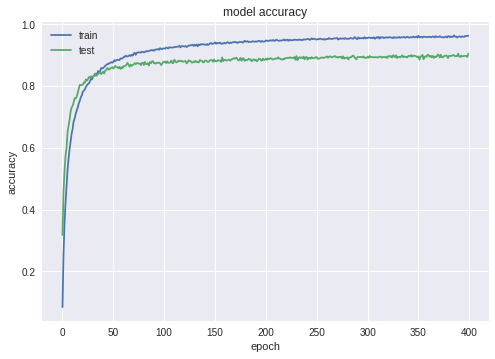

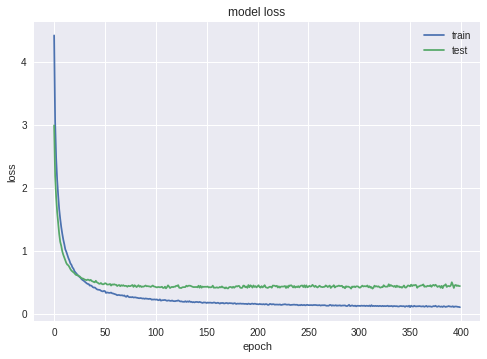

In [15]:
# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### 3. Create a dataset with predicted labels

We predict the test pictures' classes using our model and create a data frame holding these predictions togehter with all other relevant information like filenames or path to the pictures.

In [16]:
pred = model.predict_classes(X_test)
predictions= pd.DataFrame({'prediction': pred, 'label_numeric': labels_numeric_test, 'label': labels_test, 'source': source_test, 'filename':filenames_test, 'path':path_test})
#order columns
predictions = predictions[['prediction', 'label_numeric', 'label', 'source', 'filename', 'path']]
predictions.head()

,prediction,label_numeric,label,source,filename,path
27779,127,127,Tilia americana,lab,pi0057-08-1.jpg,dataset/images/lab/tilia_americana/pi0057-08-1...
27780,8,8,Acer rubrum,lab,pi2388-07-1.jpg,dataset/images/lab/acer_rubrum/pi2388-07-1.jpg
27781,106,106,Quercus alba,lab,pi0080-08-2.jpg,dataset/images/lab/quercus_alba/pi0080-08-2.jpg
27782,91,91,Pinus strobus,lab,wb1081-05-3.jpg,dataset/images/lab/pinus_strobus/wb1081-05-3.jpg
27783,58,58,Juniperus virginiana,field,13001955324151.jpg,dataset/images/field/juniperus_virginiana/1300...


### 4. Plot confusion matrix

A confusion matrix is a crosstable of predicted vs. actual classes, showing the height of the values in each cell in color intensity. For the 185 classes our data has, it is of course not what we would call a neat plot.

In [0]:
def plot_confusion_matrix(y_actu, y_pred, title='Confusion matrix', cmap=plt.cm.gray_r, figsize=(100,70), col_range_min=0, col_range_max=30):
    '''
    Creates a confusion matrix mapping actual labels vs. predicted labels, showing the height of values in each cell in color intensity.
    
    Input:
    - y_actu: actual labels
    - y_pred: predicted labels
    - title: title of the plot
    - cmap: color mapping
    - figsize: tuple of (w,h) determining the size of the plot
    - col_range_min /_max: min and max cell-value height the color intensity is based on, approx. amount of test data / number of classes
    
    Returns:
    - confusion matrix
    '''
    
    #create crosstab
    df_confusion = pd.crosstab(y_actu, y_pred.reshape(y_pred.shape[0],), rownames=['Actual'], colnames=['Predicted'], margins=True)
    
    df_conf_norm = df_confusion / df_confusion.sum(axis=1)
    
    #scale plot to requested figur size
    plt.figure(figsize=figsize)
    
    #plot crosstab
    plt.matshow(df_confusion, cmap=cmap, fignum=1) # imshow
    #plt.title(title)
    
    #apply min and max ranges
    plt.clim(col_range_min, col_range_max)
    #create colorbar for the legend
    plt.colorbar()
    #create axes ticks
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    
    #label axes
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

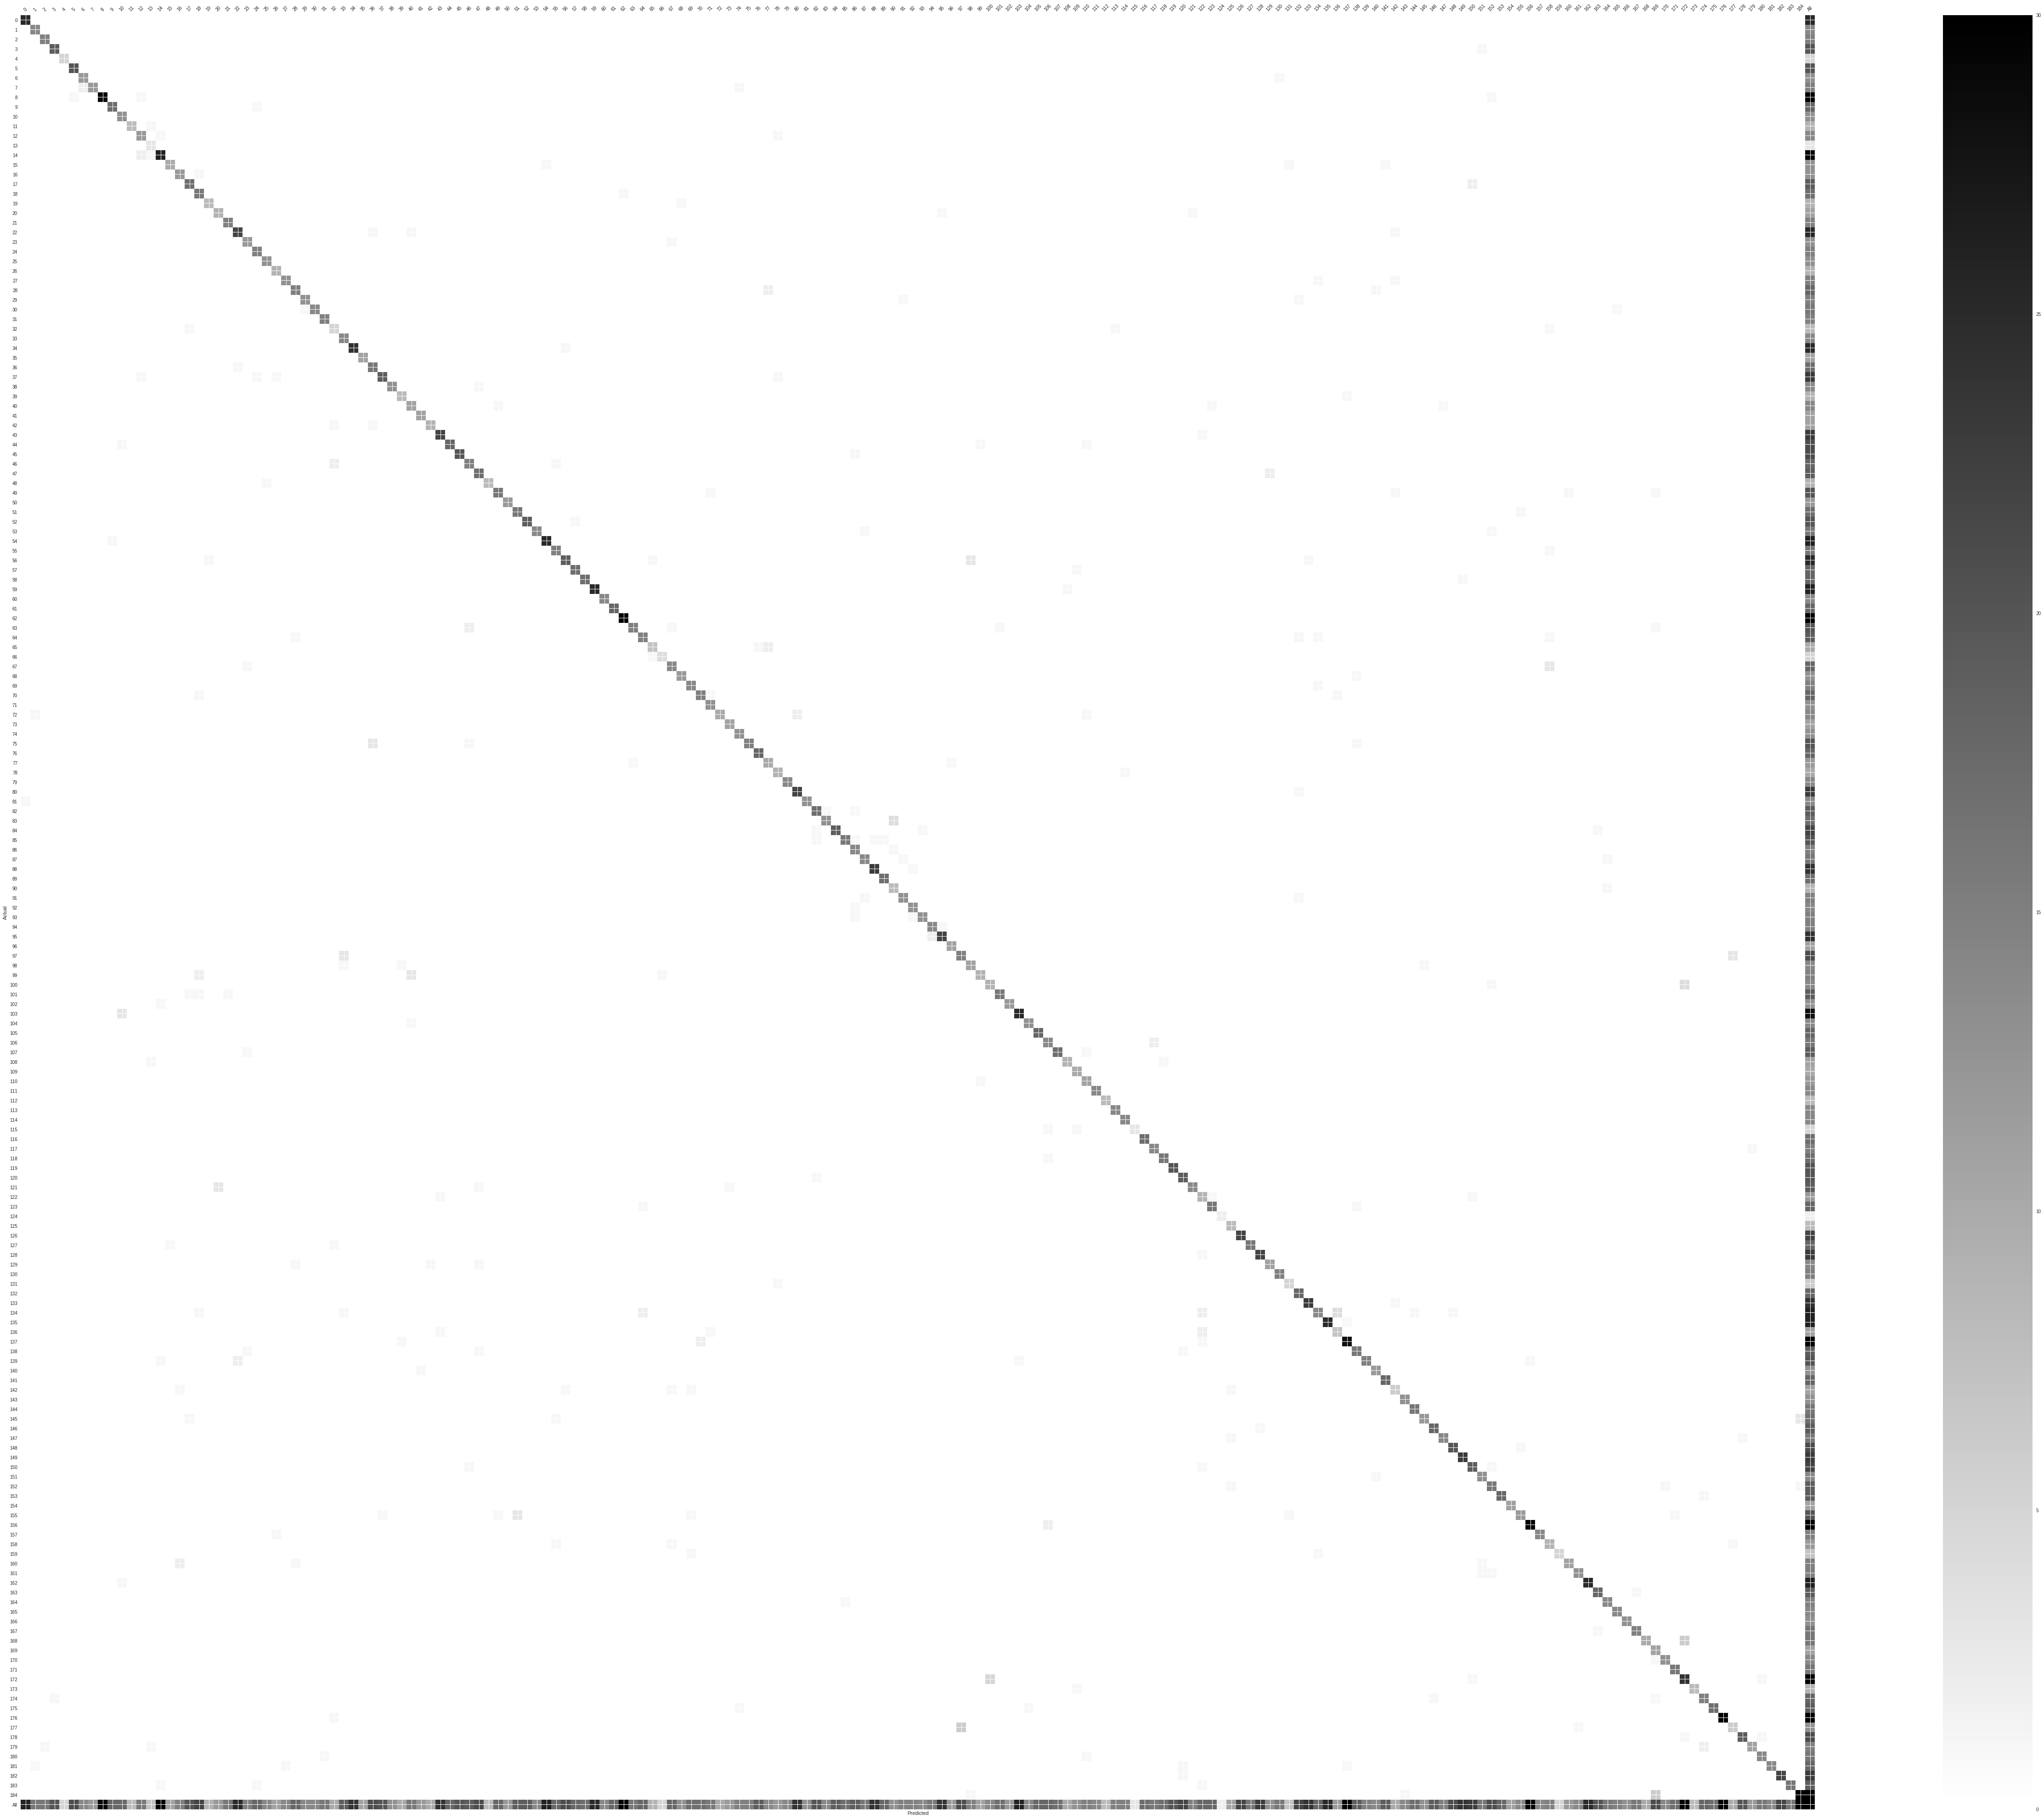

In [18]:
plot_confusion_matrix(labels_numeric_test, pred)

### Investigate the role of the amount of examples per class

Is the model making more errors when predicting classes it has had less examples to train on?
- How are the classes distributed in the training data (see histogram)?
- Can the amount of training examples predict how prone the model is to make errors when predicting on the test set? (see correlation and regression plot)
  - Here, the amount of errors is used rather than the absolute errors, as with more training examples, more errors are likelier

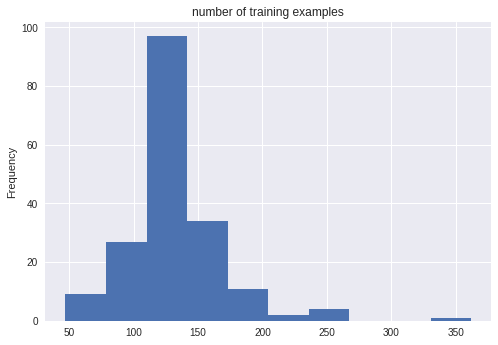

In [17]:
#number of examples per class in training set
training_examples = img_info_rand.iloc[0:index_train,:]
examples_per_label = training_examples.label.value_counts()
examples_per_label.plot(kind="hist", title="number of training examples")

The majority of classes hold approximately between 100 and 150 examples, least is about 50 examples.

In [18]:
#incorrect predictions
incorrect = predictions[predictions["label_numeric"] != predictions["prediction"]]
incorrect = incorrect[['prediction', 'label_numeric', 'label', 'source', 'filename', 'path']]

#number of mistakes per class in test set
mistakes_per_label = incorrect.label.value_counts()

#pull together in df
examples_vs_mistakes = pd.DataFrame({'examples': examples_per_label, 'errors': mistakes_per_label})
#all species no mistakes were made on appear as NA, set them to 0
examples_vs_mistakes = examples_vs_mistakes.fillna(value=0)
#calculate error amount
examples_vs_mistakes["error_amount"] = examples_vs_mistakes["errors"] / examples_vs_mistakes["examples"]

print("Correlation is", examples_vs_mistakes["error_amount"].corr(examples_vs_mistakes["examples"]))

Correlation is -0.041467630664695526


Text(0.5,1,'Amount of training examples vs errors on test set')

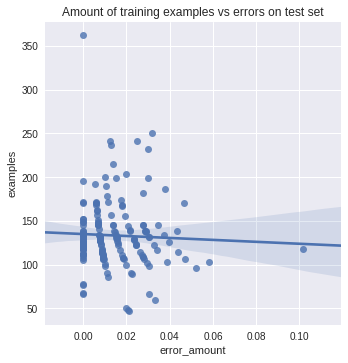

In [21]:
sns.lmplot(x='error_amount',y='examples',data=examples_vs_mistakes,fit_reg=True)
ax = plt.gca()
ax.set_title("Amount of training examples vs errors on test set")

We can observe a really slight negative correlation: The less training examples are available, the higher is the amount of errors.

### Is the performance different for lab/field pictures?

Is the model more prone to making errors when classifying pictures taken in the lab vs in the field?

- Amount of lab pictures misclassified
- Amount of field pictures misclassified

In [19]:
lab_errors = incorrect[incorrect["source"] == "lab"]
amount_lab_errors = len(lab_errors)/len(predictions[predictions["source"] == "lab"])

field_errors = incorrect[incorrect["source"] == "field"]
amount_field_errors = len(field_errors)/len(predictions[predictions["source"] == "field"])

print("Error amount lab picures: " + str(amount_lab_errors))
print("Error amount field pictures: " + str(amount_field_errors))

Error amount lab picures: 0.058033780857514074
Error amount field pictures: 0.2570694087403599


Much higher error amount on the field images.

### Show examples of classes the model could predict worst/best

On which classes did the model perform well and which were often misclassified?

List the species no errors were made on:

In [23]:
examples_vs_mistakes[examples_vs_mistakes["error_amount"] == min(examples_vs_mistakes["error_amount"])]

,errors,examples,error_amount
Abies concolor,0.0,196,0.0
Abies nordmanniana,0.0,126,0.0
Acer campestre,0.0,122,0.0
Acer griseum,0.0,105,0.0
Acer palmatum,0.0,172,0.0
Acer saccharum,0.0,149,0.0
Aesculus hippocastamon,0.0,126,0.0
Albizia julibrissin,0.0,118,0.0
Amelanchier laevis,0.0,121,0.0
Betula alleghaniensis,0.0,117,0.0


Species with the highest error rate:

In [24]:
examples_vs_mistakes[examples_vs_mistakes["error_amount"] == max(examples_vs_mistakes["error_amount"])]

,errors,examples,error_amount
Ulmus glabra,12.0,118,0.101695


Example for (one of the species with the) lowest error rate (abies nordmanniana):

<img src="http://drive.google.com/uc?export=view&id=1L-oVJRD3m2pfS0FuEQrpIzlSXHSczYxt">
          
Example for species with the highest error rate (ulmus glabra):

<img src="http://drive.google.com/uc?export=view&id=1XeO7cb3l--kY0AOAK-gM-SGKCGDddJhT">

### Visualize important picture regions 

**Gradient weighted class activation maps**

We predict the class of one image with our network. From the output, we select the column corresponding to the class that the highest probability was assigned to. Next, we get the output from the final convolutional layer (the final convolutional feature map, eg (14,14,512)). We then compute the gradient of our selected class’s output with respect to the feature map (In how far does changing the values in the feature map change the output for our selected class?). 

From these gradients, we select the maximum gradient per channel of the feature map (so the maximum gradient for each filter (512,) --> like a global max pooling layer: collapse each filter (each channel) so each feature that is detected (by the corresponding filter) in one node ((1,1,512) or (512,)) and multiply the first two dimensions oft he feature map with it (so multiply each of the 14x14 values per each of the 512 channels with the one maximum gradient value for the corresponding channel). From this, we obtain the weighted feature map (14, 14, 512), where each of the 14x14 values inside each channel is weighted by the maximum gradient of this channel. 

We then average across the channel axis into a (14, 14) heatmap (so we have one average value for each of the first two dimensions of the weighted feature map across all channels). The higher a value in this heatmap, the more does the output for our selected class depend on it. 

Then, we set all negative entries in the heatmap to zero and normalize all values by dividing them by the maximum value inside the heatmap, so that now values range from 0 to 1. Next, we resize the heatmap to the size of the image we generated the heatmap for (the input image we predicted a class for). Then, we multiply each of the heatmap’s entries by 255, to obtain a grayscale image. This is then pseudocolored. Finally, the heatmap is imposed on the original image. 

From this, we can see, which parts of the image the model mainly used to come up with a classification, as

**we highlight the feature map regions that cause the most change in the output**.


In [0]:
def generate_heatmap(img_array, model, layer_output, layer_conv, img):
    '''
    Computes a gradient weighted class activation map for an image by weighing the final convolutional 
    feature map with the gradient of the predicted class with respect to the channel and then averaging 
    along the channel (filter) axis to visualize which image regions are important for classifying the
    image.
    
    Input:
    - img_array: normalized rgb array of an image with shape (w,h,c) as expected by the model (assuming
      the amount of training examples is given on the first axis for the model input)
    - model: model to base the class activation map on
    - layer_ouput: name of the model's softmax output layer (str)
    - layer_conv: name of the final convolutional layer (this feature map is used) (str)
    - img: filename (with path) of the image corresponding to img_array, of any size
    
    Returns:
    - img with the class activation map superimposed on it 
    '''
    
    #expand img_array to fit into model: (1,w,h,c)
    x = np.expand_dims(img_array, axis=0)
    #predict the corresponding class
    pred_class = np.argmax(model.predict(x))
    layer_output_name = layer_output
    layer_conv_name = layer_conv
    #get indices of the relevant layers
    output_layer_idx = [idx for idx, layer in enumerate(model.layers) if layer.name == layer_output_name][0]
    conv_layer_idx = [idx for idx, layer in enumerate(model.layers) if layer.name == layer_conv_name][0]
    #change softmax layer to linear activation layer to obtain better results
    model.layers[output_layer_idx].activation = activations.linear
    #apply changes (to new model instance, original model stays untouched)
    model_maps = utils.apply_modifications(model)
    #generate class activation map
    heatmap = visualize_cam(model=model_maps, layer_idx=output_layer_idx, filter_indices=[pred_class], seed_input=x, penultimate_layer_idx=conv_layer_idx)
    #read image the map is to be superimposed on
    img = cv2.imread(img)
    #resize map to the size of img
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    #superimpose
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    
    return superimposed_img

Data frame containing one lab picture per class. 

In [0]:
img_info = pd.read_csv("img_info.csv")
img_info_lab = img_info[img_info["source"] == "lab"]

k = 0
for index, row in img_info_lab.iterrows():
    if k == 0:
        if row["labels_integer"] == k:
            example_per_label_lab = row
            example_per_label_lab = pd.DataFrame([example_per_label_lab])
            k += 1
    elif k == 185:
        break
    else:
        if row["labels_integer"] == k:
            example_per_label_lab = example_per_label_lab.append(row)
            k +=1

Generate heatmap for each lab example (one per class).

In [0]:
output_path = "heatmaps/lab/"
col_index_path = example_per_label_lab.columns.get_loc("image_path")
col_index_filename = example_per_label_lab.columns.get_loc("filename")
col_index_label = example_per_label_lab.columns.get_loc("species")

for i in range(len(example_per_label_lab)):
  path = example_per_label_lab.iloc[i, col_index_path]
  img = cv2.imread(path)
  img = cv2.resize(img, (64, 64))
  img = img/255
  heatmap = generate_heatmap(img, model, "dense_2", "activation_2", path)
  filename = example_per_label_lab.iloc[i, col_index_label] + "_heatmap_" +  example_per_label_lab.iloc[i, col_index_filename]
  cv2.imwrite(output_path + filename, heatmap)

Data frame containing one field picture per class (for some reason, there are no field images of species "ulmus procera	" corresponding to the numeric label 136, so that one is skipped in the code below).

In [0]:
img_info = pd.read_csv("img_info.csv")
img_info_field = img_info[img_info["source"] == "field"]

k = 0
for index, row in img_info_field.iterrows():
    if k == 0:
        if row["labels_integer"] == k:
            example_per_label_field = row
            example_per_label_field = pd.DataFrame([example_per_label_field])
            k += 1
    elif k == 185:
        break
    elif k == 136:
        k +=1
    else:
        if row["labels_integer"] == k:
            example_per_label_field = example_per_label_field.append(row)
            k +=1

In [0]:
output_path = "heatmaps/field/"
col_index_path = example_per_label_field.columns.get_loc("image_path")
col_index_filename = example_per_label_field.columns.get_loc("filename")
col_index_label = example_per_label_field.columns.get_loc("species")

for i in range(len(example_per_label_field)):
  path = example_per_label_field.iloc[i, col_index_path]
  img = cv2.imread(path)
  img = cv2.resize(img, (64, 64))
  img = img/255
  heatmap = generate_heatmap(img, model, "dense_2", "activation_2", path)
  filename = example_per_label_field.iloc[i, col_index_label] + "_heatmap_" +  example_per_label_field.iloc[i, col_index_filename]
  cv2.imwrite(output_path + filename, heatmap)

Examples of lab picture heatmaps:

<img src="http://drive.google.com/uc?export=view&id=1SE3rvIH3rEjE6mRpxPzSghkaA49yWGsI">

Examples of field picture heatmaps:

<img src="http://drive.google.com/uc?export=view&id=13AOGuAUiueGLcP2SiDFdftUHEbCM3ukx">

We can see that **for the lab pictures, often not the leaf itself but the tools lying next to the image like a ruler are used by the CNN**. From this we can see, that it is able to detect  patterns, but not to distinguish between those that are relevant for the task and those that are not. We therefore need to clean the input more!

How the leaves are really identified and distinguished can be observed better for the field images.

Heatmap for the species yielding the lowest error rate (abies nordmanniana):

<img src="http://drive.google.com/uc?export=view&id=1vGiH0fXgdpj4p0EwjxtOwibEWJ4EQcS8">

Heatmap for the species yielding the highest error rate (ulmus glabra):

<img src="http://drive.google.com/uc?export=view&id=1rR7DEcfASpvpABWBqdb4NQ4tlbcCVxhH">

## Conclusion

Our CNN increased performance as compared to the computer vision algorithm implemented by , doing so with a relatively simple architecture. Specifically, top-1 accuracy rose from ca. 72% (computer vision algorithm) to 89% (our model), training on on average 133 examples per each of the 185 classes of tree species in Northeastern America. This emphasizes how promising the approach of CNNs is for image classification. 

However, it seems that for tree leaf pictures taken in the lab, the colorbars present on the pictures drew our models' attention, as they seem to have been used to classify these pictures (see the heatmaps). To really only rely on the leaves themselves, in future work, only pictures showing noting but the leaf against a background should be used to train a CNN. This is a clear limitation in this project, especially in the light of the differences in error rates between lab and field pictures.

What is more, a bigger dataset, better balanced for the different species could be aqcuired and used. Also, it may be reasonable to use picture versions that have a higher resolution than 64x64 pixels as input to the CNN to further boost performance. In this project, although using Google Colaboratory, computional resources were not sufficient to do so. Especially performance for tree species with relatively small leaves could profit from this approach.

##Clean-up

Terminate the kernel and free memory resources.

In [0]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)